In [1]:
import yfinance as yf
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import scipy.stats as si
import random 
from tqdm import tqdm

Inititalize Option Objects 

In [2]:
class Call_Option(object):
    
    def __init__(self, S, K, T, r, q, sigma):
        self.S = S 
        self.K = K
        self.T = T
        self.r = r
        self.q = q
        self.sigma = sigma
        
        self.d1 = (np.log(self.S / self.K) + (self.r - self.q + 0.5 * self.sigma ** 2) * self.T) / (self.sigma * np.sqrt(self.T))
        self.d2 = (np.log(self.S / self.K) + (self.r - self.q - 0.5 * self.sigma ** 2) * self.T) / (self.sigma * np.sqrt(self.T))
    
        self.price = (self.S * np.exp(-self.q * self.T) * si.norm.cdf(self.d1, 0, 1) - self.K * np.exp(-self.r * self.T) * si.norm.cdf(self.d2, 0, 1))
        

        self.payout = pd.DataFrame(list(range(int(self.K*0), int(self.K*2), 1)), columns = ['Price'])
        self.payout['Zero'] = 0
        self.payout['Diff'] = self.payout['Price'] -  self.K
        self.payout['Payout'] = self.payout[['Zero', 'Diff']].max(axis=1) - self.price
        self.payout.index = self.payout['Price']
        self.payout.drop(['Zero', 'Diff', 'Price'], inplace=True, axis=1)
        
        self.delta = si.norm.cdf(self.d1, 0, 1)
        self.gamma = si.norm.pdf(self.d1, 0, 1)/(self.S*self.sigma*np.sqrt(self.T))
        self.vega = (self.S*si.norm.pdf(self.d1, 0, 1)*np.sqrt(self.T))/100
        self.theta = (-self.S*si.norm.pdf(self.d1, 0, 1)*self.sigma/(2*np.sqrt(self.T)) - self.r*self.K*np.exp(-self.r*self.T)*si.norm.cdf(self.d2, 0, 1) )/365
        self.rho = (self.K*self.T*np.exp(-self.r*self.T)*si.norm.cdf(self.d2, 0, 1)) /100
        
        
#     def get_impl_vol(self, market_price):
#         self.market_price = market_price
#         self.maxiter = 1000
#         self.vol = 1

#         new_sig = 1
#         while (self.market_price/self.price - 1) <= 0.0001:
#             if self.market_price > self.price:
#                 self.vol*=1.01
#             else:
#                 self.vol*=0.99
#         return self.vol

# #         while self.epsilon > self.tol:
# #             self.count += 1
# #             if self.count >= self.maxiter:
# #                 print('Breaking on Count')
# #                 break
# #             self.orig_vol = self.vol
# #             self.d1_new = (np.log(self.S / self.K) + (self.r - self.q + 0.5 * self.vol ** 2) * self.T) / (self.vol * np.sqrt(self.T))
# #             self.d2_new = (np.log(self.S / self.K) + (self.r - self.q - 0.5 * self.vol ** 2) * self.T) / (self.vol * np.sqrt(self.T))
    
# #             self.func_val = (self.S * np.exp(-self.q * self.T) * si.norm.cdf(self.d1_new, 0, 1) - self.K * np.exp(-self.r * self.T) * si.norm.cdf(self.d2_new, 0, 1)) - self.market_price     
# #             self.new_vega = self.S*si.norm.pdf(self.d1_new, 0, 1)*np.sqrt(self.T)

# #             self.vol = -self.func_val / self.new_vega + self.vol
            
# #             self.epsilon = abs((self.vol-self.orig_vol)/ self.orig_vol)
        
# #         return self.vol
        
            
# #         get impl vol as a function 
        
class Put_Option(object):
    
    def __init__(self, S, K, T, r, q, sigma):
        self.S = S 
        self.K = K
        self.T = T
        self.r = r
        self.q = q
        self.sigma = sigma
        
        
        self.d1 = (np.log(self.S / self.K) + (self.r - self.q + 0.5 * self.sigma ** 2) * self.T) / (self.sigma * np.sqrt(self.T))
        self.d2 = (np.log(self.S / self.K) + (self.r - self.q - 0.5 * self.sigma ** 2) * self.T) / (self.sigma * np.sqrt(self.T))
    
        self.price = (-self.S * np.exp(-self.q * self.T) * si.norm.cdf(-self.d1, 0.0, 1.0) + self.K * np.exp(-self.r * self.T) * si.norm.cdf(-self.d2, 0.0, 1.0))  
        
        self.payout = pd.DataFrame(list(range(int(self.K*0), int(self.K*2), 1)), columns = ['Price'])
        self.payout['Zero'] = 0
        self.payout['Diff'] = self.K - self.payout['Price'] 
        self.payout['Payout'] = self.payout[['Zero', 'Diff']].max(axis=1) - self.price
        self.payout.index = self.payout['Price']
        self.payout.drop(['Zero', 'Diff', 'Price'], inplace=True, axis=1)
        
        self.delta = -si.norm.cdf(-self.d1, 0.0, 1.0)
        self.gamma = si.norm.pdf(self.d1, 0.0, 1.0)/(self.S*self.sigma*np.sqrt(self.T))
        self.vega = (self.S*si.norm.pdf(self.d1, 0.0, 1.0)*np.sqrt(self.T) )/ 100
        self.theta = (-self.S*si.norm.pdf(self.d1, 0, 1)*self.sigma/(2*np.sqrt(self.T)) + self.r*self.K*np.exp(-self.r*self.T)*si.norm.cdf(-self.d2, 0, 1) )/ 365
        self.rho = (-self.K*self.T*np.exp(-self.r*self.T)*si.norm.cdf(-self.d2, 0, 1) )/ 100
        

class Option_Payout(object):
    
    def __init__(self, S, K, T, r, q, sigma, Call, Buy, Amount):
        assert type(Call) == bool and type(Buy) == bool
        self.S = S 
        self.K = K
        self.T = T
        self.r = r
        self.q = q
        self.sigma = sigma
        self.Call = Call
        self.Buy = Buy 
        self.Amount = Amount
        
        if self.Call:
            self.Option = Call_Option(self.S, self.K, self.T, self.r, self.q, self.sigma)
            if self.Buy: 
                self.payout = self.Option.payout * self.Amount
                self.delta = self.Option.delta * self.Amount
                self.gamma = self.Option.gamma * self.Amount
                self.vega = self.Option.vega * self.Amount
                self.theta = self.Option.theta * self.Amount
                self.rho = self.Option.rho * self.Amount
                self.price = self.Option.price * self.Amount
            if not self.Buy:
                self.payout = self.Option.payout * self.Amount * -1
                self.payout = self.Option.payout * self.Amount *-1
                self.delta = self.Option.delta * self.Amount *-1
                self.gamma = self.Option.gamma * self.Amount *-1
                self.vega = self.Option.vega * self.Amount *-1
                self.theta = self.Option.theta * self.Amount *-1
                self.rho = self.Option.rho * self.Amount *-1
                self.price = self.Option.price * self.Amount *-1
                
        if not self.Call:
            self.Option = Put_Option(self.S, self.K, self.T, self.r, self.q, self.sigma)
            if self.Buy: 
                self.payout = self.Option.payout * self.Amount
                self.delta = self.Option.delta * self.Amount
                self.gamma = self.Option.gamma * self.Amount
                self.vega = self.Option.vega * self.Amount
                self.theta = self.Option.theta * self.Amount
                self.rho = self.Option.rho * self.Amount
                self.price = self.Option.price * self.Amount
                
            if not self.Buy:
                self.payout = self.Option.payout * self.Amount * -1
                self.payout = self.Option.payout * self.Amount *-1
                self.delta = self.Option.delta * self.Amount *-1
                self.gamma = self.Option.gamma * self.Amount *-1
                self.vega = self.Option.vega * self.Amount *-1
                self.theta = self.Option.theta * self.Amount *-1
                self.rho = self.Option.rho * self.Amount *-1
                self.price = self.Option.price * self.Amount *-1

class Stock_Payout(object):
    
    def __init__(self, K, Buy, Amount):
        self.K = K
        self.Buy = Buy 
        self.Amount = Amount 

        self.payout = pd.DataFrame(list(range(int(self.K*0), int(self.K*2), 1)), columns = ['Price'])
        self.payout['Zero'] = 0
        self.payout['Payout'] = self.payout['Price'] -  self.K
        self.payout.index = self.payout['Price']
        self.payout.drop(['Zero', 'Price'], inplace=True, axis=1)
            
        self.gamma = 0
        self.vega = 0
        self.theta = 0
        self.rho = 0

        if self.Buy:
            self.delta = 1 * self.Amount
            self.price = self.K * self.Amount

        if not self.Buy:
            self.delta = -1 * self.Amount
            self.price = -1 * self.K * self.Amount

def get_iv(S, K, T, r, q, call, actual_price):
    
    new_sig = 1
    if call:
        while (abs(actual_price/Call_Option(S, K, T, r, q, new_sig).price - 1) >= 0.00001):
            if actual_price > Call_Option(S, K, T, r, q, new_sig).price:
                new_sig*=1.001
            else:
                new_sig*=0.999
        return new_sig
    else:
        while (abs(actual_price/Put_Option(S, K, T, r, q, new_sig).price - 1) >= 0.00001):
            if actual_price > Put_Option(S, K, T, r, q, new_sig).price:
                new_sig*=1.001
            else:
                new_sig*=0.999
    return new_sig

def get_vola(SerIn, window):
    return (SerIn.rolling(window).std())*np.sqrt(252)

Download Data

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
The Vola is 0.12
The Stock Price is 381.57
10%+ means 419.73


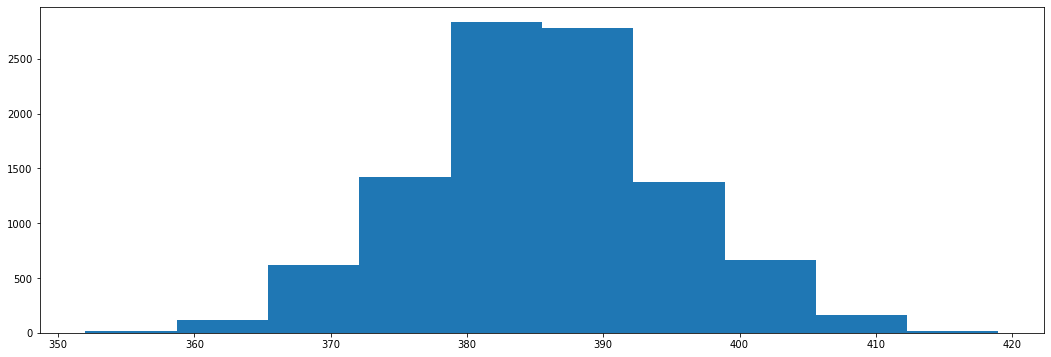

385.595


In [5]:
stock = "QQQ"
days = 8
tries =10000

stock = yf.download(stock)
stock['Return'] = stock['Adj Close'].pct_change()
rate = yf.download('^IRX')['Adj Close']/100
r = rate[-1]/252
stock['Vola 21'] = get_vola(stock['Return'], 21)
stock['Vola 63'] = get_vola(stock['Return'], 63)
stock['Vola 126'] = get_vola(stock['Return'], 126)
stock['Vola 252'] = get_vola(stock['Return'], 252)
stock['Expected Vola'] = (0.4*stock['Vola 21'])+(0.3*stock['Vola 63'])+(0.2*stock['Vola 126'])+(0.1*stock['Vola 252'])
vol =  (stock['Expected Vola'][-1])/ np.sqrt(252)

print(f"The Vola is {round(stock['Expected Vola'][-1],2)}")
print(f'The Stock Price is {round(stock["Adj Close"][-1],2)}')
print(f'10%+ means {round(stock["Adj Close"][-1]*1.1, 2)}')

d_return = stock['Adj Close'].pct_change()[-int(100):].to_list()
mean_return = np.mean(d_return)
return_std = np.std(d_return)
final_returns = (mean_return + return_std * np.random.normal(size=(tries,days))).tolist()

final_values = []
for i in range(len(final_returns)):
    a = final_returns[i]
    values = []
    values.append(stock['Adj Close'][-1])
    for i in range(len(a)):
        values.append((values[i]*(1+a[i])))
    final_values.append(values)

values_df = pd.DataFrame(final_values).transpose()

last_days = values_df.iloc[-1].tolist()
last_days_rounded = [round(num, 0) for num in last_days]

plt.figure(figsize=(18,6))
plt.hist(last_days_rounded)
plt.show()

print(np.mean(last_days_rounded))

Access Option Features and calculate IV and Payout

calculate IV?1


  0%|          | 0/3 [00:00<?, ?it/s]

calculating IV..


100%|██████████| 3/3 [00:39<00:00, 13.02s/it]


The cost of the Strategy is 378.0038137982231
The Total Delta is 45.92675554162486
The Total Gamma is -1.3959199845566357
The Total Vega is -3.711536185912534
The Total Theta is 1.5421786311272814
The Total Rho is 3.758086276076094

doing Monte Carlo..

The Expected Value for 20 days is 149.67
385.02014
[382, 394]
 The chance of being profitable is 66.0 % 


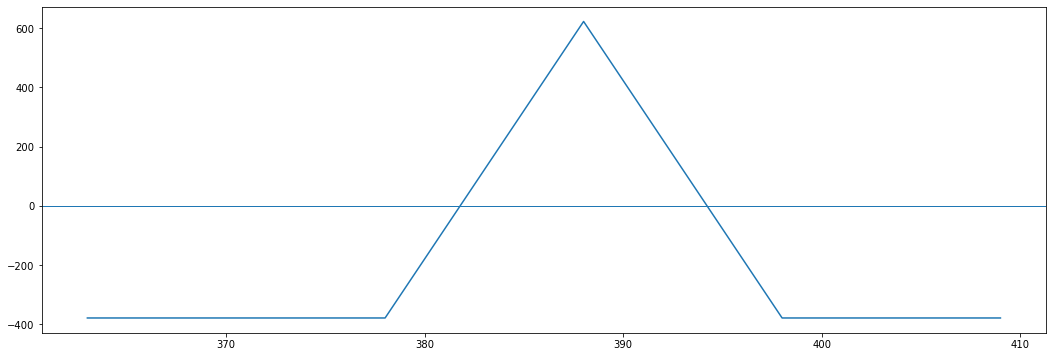

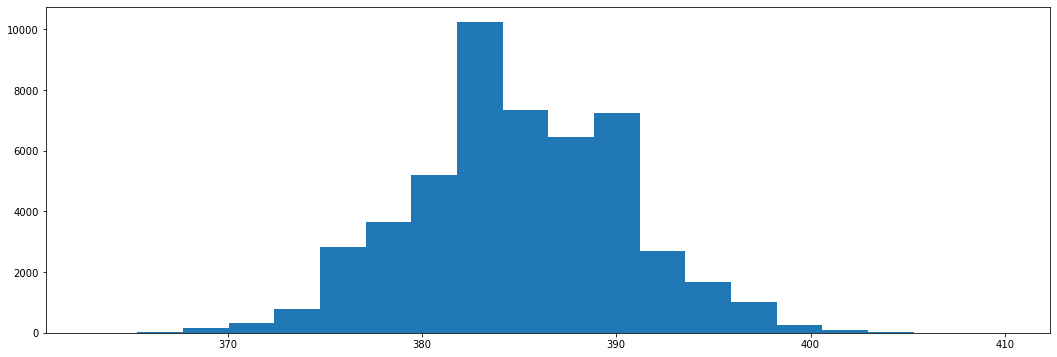

The Expected Value for 60 days is 155.21
385.27086
[382, 394]
 The chance of being profitable is 67.0 % 


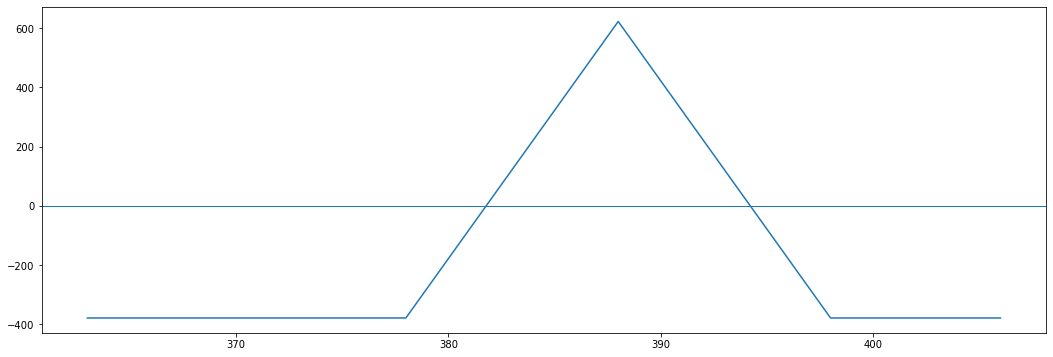

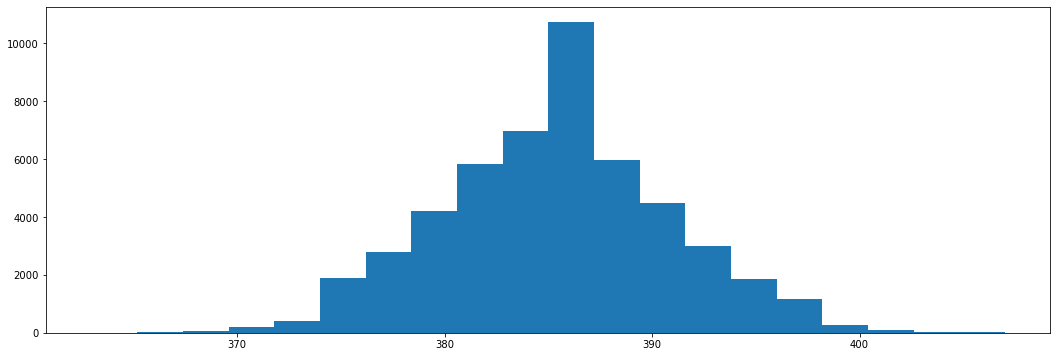

The Expected Value for 120 days is 30.91
384.43
[382, 394]
 The chance of being profitable is 51.0 % 


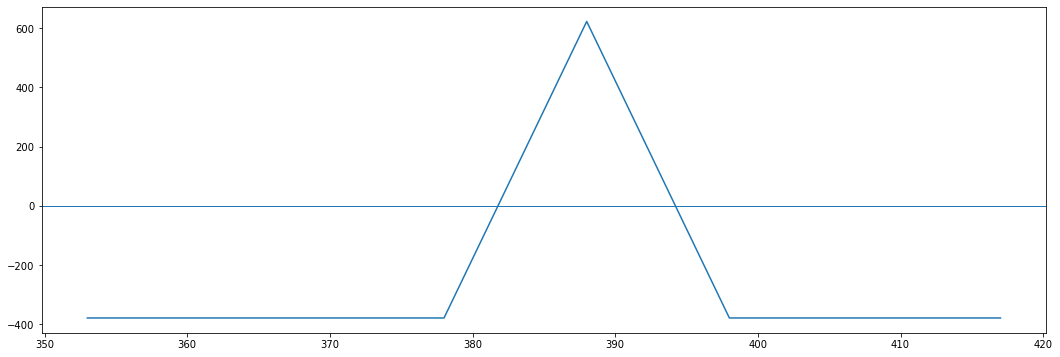

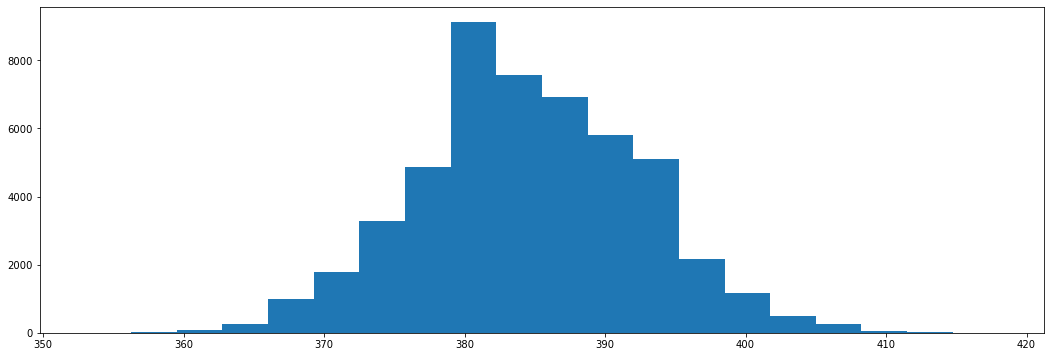

The Expected Value for 240 days is -46.93
384.55746
[382, 394]
 The chance of being profitable is 41.0 % 


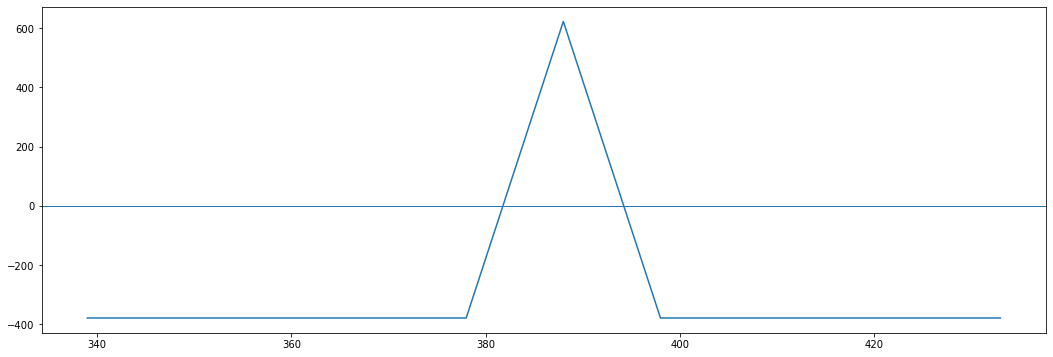

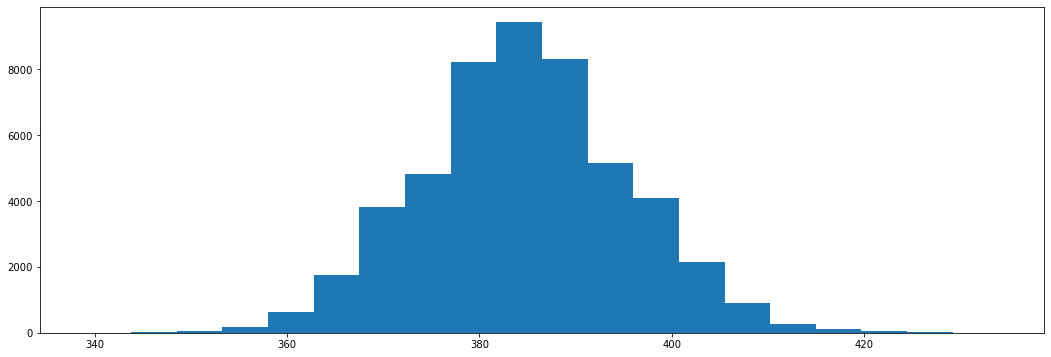

The Expected Value for 480 days is -134.61
384.71284
[382, 394]
 The chance of being profitable is 30.0 % 


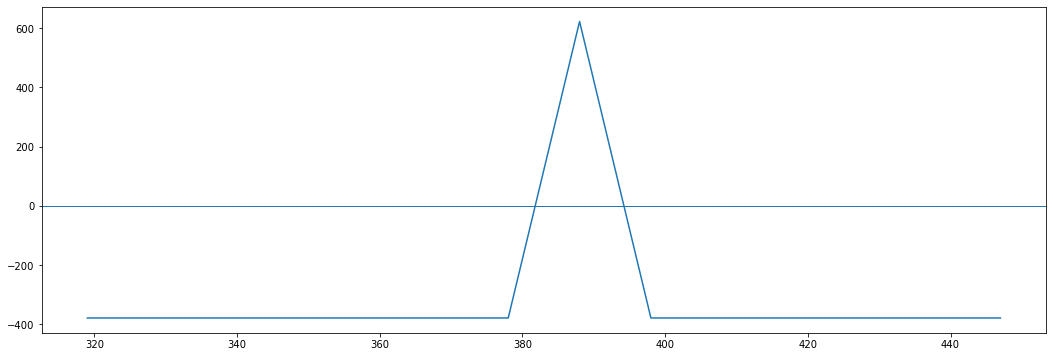

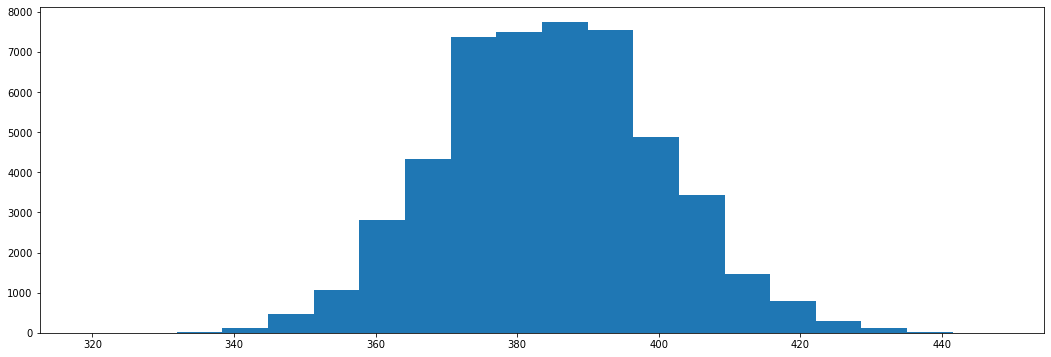

                     1         2         3
Buy                  1     False         1
Call                 1         1         1
Amount             100       200       100
Market Price       4.6      0.45      0.08
Strike             378       388       398
Stock Price     380.58    380.58    380.58
Days                 8         8         8
Vola          0.107106  0.106433  0.145507


In [6]:
calculate_iv = bool(input('calculate IV?'))
tries = 50000

days = 5

lookbackperiod = 100

if True:
    print('calculating IV..')
    option_features = pd.read_excel('Inputs.xlsx', index_col=0)
    option_features.fillna(False, inplace=True)
    for i in tqdm(range(len(option_features.columns))):
        if (option_features.iloc[3,i] > 0):
            option_features.iloc[7,i] = get_iv(stock['Adj Close'][-1], option_features.iloc[4,i], option_features.iloc[6,i]/365, rate[-1], 0, option_features.iloc[1,i], option_features.iloc[3,i])
        
list_of_payouts = []
prices = []
deltas = []
gammas = []
vegas = []
thetas = []
rhos = []
        
for i in range(len(option_features.columns)):
    list_of_payouts.append(Option_Payout(stock['Adj Close'][-1], option_features.iloc[4,i], option_features.iloc[6,i]/365, rate[-1], 0, option_features.iloc[7,i], bool(option_features.iloc[1,i]), bool(option_features.iloc[0,i]), option_features.iloc[2,i]).payout)
    prices.append(Option_Payout(stock['Adj Close'][-1], option_features.iloc[4,i], option_features.iloc[6,i]/365, rate[-1], 0, option_features.iloc[7,i],bool(option_features.iloc[1,i]), bool(option_features.iloc[0,i]), option_features.iloc[2,i]).price)
    deltas.append(Option_Payout(stock['Adj Close'][-1], option_features.iloc[4,i], option_features.iloc[6,i]/365, rate[-1], 0, option_features.iloc[7,i],bool(option_features.iloc[1,i]), bool(option_features.iloc[0,i]), option_features.iloc[2,i]).delta)
    gammas.append(Option_Payout(stock['Adj Close'][-1], option_features.iloc[4,i], option_features.iloc[6,i]/365, rate[-1], 0, option_features.iloc[7,i],bool(option_features.iloc[1,i]), bool(option_features.iloc[0,i]), option_features.iloc[2,i]).gamma)
    vegas.append(Option_Payout(stock['Adj Close'][-1], option_features.iloc[4,i], option_features.iloc[6,i]/365, rate[-1], 0, option_features.iloc[7,i],bool(option_features.iloc[1,i]), bool(option_features.iloc[0,i]), option_features.iloc[2,i]).vega)
    thetas.append(Option_Payout(stock['Adj Close'][-1], option_features.iloc[4,i], option_features.iloc[6,i]/365, rate[-1], 0, option_features.iloc[7,i],bool(option_features.iloc[1,i]), bool(option_features.iloc[0,i]), option_features.iloc[2,i]).theta)
    rhos.append(Option_Payout(stock['Adj Close'][-1], option_features.iloc[4,i], option_features.iloc[6,i]/365, rate[-1], 0, option_features.iloc[7,i],bool(option_features.iloc[1,i]), bool(option_features.iloc[0,i]), option_features.iloc[2,i]).rho)

result = pd.concat(list_of_payouts, axis=1, join="inner")

result['Total']= result.iloc[:,].sum(axis=1)

print(f'The cost of the Strategy is {sum(prices)}')
print(f'The Total Delta is {sum(deltas)}')
print(f'The Total Gamma is {sum(gammas)}')
print(f'The Total Vega is {sum(vegas)}')
print(f'The Total Theta is {sum(thetas)}')
print(f'The Total Rho is {sum(rhos)}')
print('')
print('doing Monte Carlo..')
print('')


for lookbackperiod in [20, 60, 120, 240, 480]:
    
    d_return = stock['Adj Close'].pct_change()[-int(lookbackperiod):].to_list()
    mean_return = np.mean(d_return)
    return_std = np.std(d_return)
    final_returns = (mean_return + return_std * np.random.normal(size=(tries,days))).tolist()

    final_values = []
    for i in range(len(final_returns)):
        a = final_returns[i]
        values = []
        values.append(stock['Adj Close'][-1])
        for i in range(len(a)):
            values.append((values[i]*(1+a[i])))
        final_values.append(values)

    values_df = pd.DataFrame(final_values).transpose()

    last_days = values_df.iloc[-1].tolist()
    last_days_rounded = [round(num, 0) for num in last_days]

    last_days_times_payout = []
    for i in last_days_rounded:
        last_days_times_payout.append(result.iloc[int(i),3])

    print(f'The Expected Value for {lookbackperiod} days is {round(sum(last_days_times_payout)/tries, 2)}')
    
    breakevens = []
    result['Breakeven'] = ((result['Total'].shift(-1) < 0) & (result['Total'].shift(1) > 0) | (result['Total'].shift(-1) > 0) & (result['Total'].shift(1) < 0)) & (result['Total'] > 0)
    for i in range(len(result['Total'])):
        if result.iloc[i,4]:
            breakevens.append(result.index[i])
        else:
            continue
    zscores = [((x-np.mean(last_days_rounded))/(np.std(last_days_rounded))) for x in breakevens] 
    
    print(np.mean(last_days_rounded))
    print(breakevens)
    print(f' The chance of being profitable is {round((abs(si.norm.sf(zscores[0]) - si.norm.sf(zscores[1])))*100, 0)} % ')
    
    fig = plt.figure(figsize=(18,6))
    ax  = fig.add_subplot()
    line, = ax.plot(result.index[int(min(last_days_rounded)):int(max(last_days_rounded))], result['Total'][int(min(last_days_rounded)):int(max(last_days_rounded))])
    ax.axhline(linewidth=1)
    plt.show()

    plt.figure(figsize=(18,6))
    plt.hist(last_days_rounded, bins=20)
    plt.show()

print(option_features)

In [58]:
print(np.mean(d_return))
print(np.std(d_return))

0.001922041660511601
0.02161788659936142


In [379]:
 rate[-1]

0.00044999998062849044

In [296]:
result.to_excel('test.xlsx')

In [138]:
S = stock['Adj Close'][-1]
K = 280
T = 15/365
r = rate[-1]
q = 0
sigma = stock['Expected Vola'][-1]

Call = Call_Option(S, K, T, r, q, sigma)

sigma = Call.get_impl_vol(4.95)

print(f'The Stock Price is: {stock["Adj Close"][-1]}')
print(f'The Rate is: {r}')

print(f'The Expected Vola is: {stock["Expected Vola"][-1]}')
print(f'The Implied Vola is: {sigma}')

The Stock Price is: 266.29998779296875
The Rate is: 0.00048000000417232515
The Expected Vola is: 0.15605315026780775
The Implied Vola is: 1


Create Strategy to view Greeks 

The stock Price is 266.3
How many Options are needed?
3
How many Stocks are needed?
0
What is the 1. Options Strike? 280
280

Is the 1. Option a Call? 1
True

Are you buying the 1. Option? 1
True

How many of the 1. Option do you need? 100
100

---   1. Option   ---

The Price is: 200.33239959810203

The Delta is: 21.849869030633396

The Gamma is: 1.7878258691848088

The Vega is: 35.363905332914364

The Theta is: -3.2947869721012877

The Rho is: 11.39050059681583

What is the 2. Options Strike? 290
290

Is the 2. Option a Call? 1
True

Are you buying the 2. Option? 
False

How many of the 2. Option do you need? 200
200

---   2. Option   ---

The Price is: -133.39377688163907

The Delta is: -17.903152878287642

The Gamma is: -1.9608970270461874

The Vega is: -38.787321532422894

The Theta is: 3.6117307062307606

The Rho is: -9.395396043522986

What is the 3. Options Strike? 300
300

Is the 3. Option a Call? 1
True

Are you buying the 3. Option? 1
True

How many of the 3. Option do you 

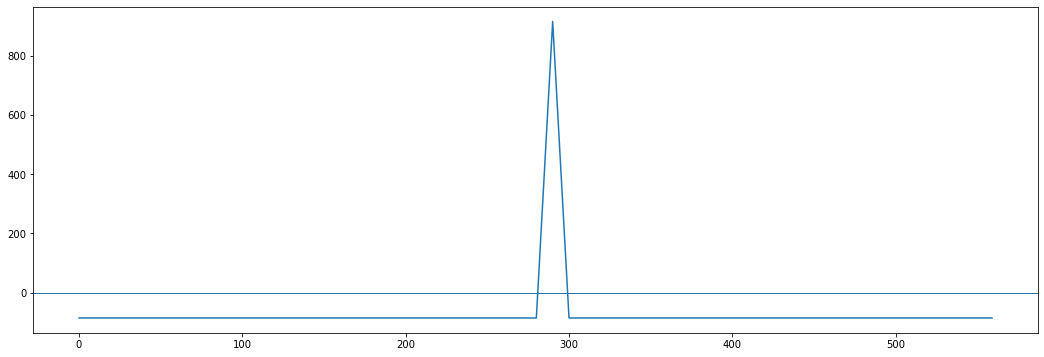

In [99]:
%matplotlib inline

print(f'The stock Price is {round(S,2)}')

number_of_options = int(input('How many Options are needed?\n'))

number_of_stocks = int(input('How many Stocks are needed?\n'))

list_of_payouts = []
prices = []
deltas = []
gammas = []
vegas = []
thetas = []
rhos = []

for i in range(number_of_options):
    K = int(input(f'What is the {i+1}. Options Strike? '))
    print(K)
    print('')
    
    Call = bool(input(f'Is the {i+1}. Option a Call? '))
    print(Call)
    print('')
    
    Buy = bool(input(f'Are you buying the {i+1}. Option? '))
    print(Buy)
    print('')
    
    Amount = int(input(f'How many of the {i+1}. Option do you need? '))
    print(Amount)
    print('')
    
    print(f'---   {i+1}. Option   ---')
    print('')
    
    print(f'The Price is: {Option_Payout(S, K, T, r, q, sigma, Call, Buy, Amount).price}')
    print('')
    
    print(f'The Delta is: {Option_Payout(S, K, T, r, q, sigma, Call, Buy, Amount).delta}')
    print('')
          
    print(f'The Gamma is: {Option_Payout(S, K, T, r, q, sigma, Call, Buy, Amount).gamma}')
    print('')
    
    print(f'The Vega is: {Option_Payout(S, K, T, r, q, sigma, Call, Buy, Amount).vega}')
    print('')
          
    print(f'The Theta is: {Option_Payout(S, K, T, r, q, sigma, Call, Buy, Amount).theta}')
    print('')
          
    print(f'The Rho is: {Option_Payout(S, K, T, r, q, sigma, Call, Buy, Amount).rho}')
    print('')
          
    list_of_payouts.append(Option_Payout(S, K, T, r, q, sigma, Call, Buy, Amount).payout)
    prices.append(Option_Payout(S, K, T, r, q, sigma, Call, Buy, Amount).price)
    deltas.append(Option_Payout(S, K, T, r, q, sigma, Call, Buy, Amount).delta)
    gammas.append(Option_Payout(S, K, T, r, q, sigma, Call, Buy, Amount).gamma)
    vegas.append(Option_Payout(S, K, T, r, q, sigma, Call, Buy, Amount).vega)
    thetas.append(Option_Payout(S, K, T, r, q, sigma, Call, Buy, Amount).theta)
    rhos.append(Option_Payout(S, K, T, r, q, sigma, Call, Buy, Amount).rho)

    
for i in range(number_of_stocks):
    K = int(input(f'What is the {i+1}. Stocks Price? '))
    print(K)
    print('')
    
    Buy = bool(input(f'Are you buying the {i+1}. Stock? '))
    print(Buy)
    print('')
    
    Amount = int(input(f'How many of the {i+1}. Stock do you need? '))
    print(Amount)
    print('')
    
    print(f'---   {i+1}. Stock   ---')
    print('')
    
    print(f'The Price is: {Stock_Payout(S, Buy, Amount).price}')
    print('')
    
    print(f'The Delta is: {Stock_Payout(S, Buy, Amount).delta}')
    print('')

          
    list_of_payouts.append(Stock_Payout(K, Buy, Amount).payout)
    prices.append(Stock_Payout(K, Buy, Amount).price)
    deltas.append(Stock_Payout(K, Buy, Amount).delta)

    
result = pd.concat(list_of_payouts, axis=1, join="inner")

result['Total']= result.iloc[:,].sum(axis=1)

fig = plt.figure(figsize=(18,6))
ax  = fig.add_subplot()
line, = ax.plot(result.index, result['Total'])
ax.axhline(linewidth=1)


print(f'The cost of the Strategy is {sum(prices)}')
print(f'The Total Delta is {sum(deltas)}')
print(f'The Total Gamma is {sum(gammas)}')
print(f'The Total Vega is {sum(vegas)}')
print(f'The Total Theta is {sum(thetas)}')
print(f'The Total Rho is {sum(rhos)}')



In [122]:
%matplotlib inline

# download = input('Dowload?')

# name = input(name)

print(f'The stock Price is {round(S,2)}')

days = int(input('how many days?'))

years = days/365

number_of_options = int(input('How many Options are needed?\n'))

number_of_stocks = int(input('How many Stocks are needed?\n'))


list_of_payouts = []

for i in range(number_of_options):
    K = int(input(f'What is the {i+1}. Options Strike? '))
    print(K)
    print('')
    
    Call = bool(input(f'Is the {i+1}. Option a Call? '))
    print(Call)
    print('')
    
    Buy = bool(input(f'Are you buying the {i+1}. Option? '))
    print(Buy)
    print('')
    
    Amount = int(input(f'How many of the {i+1}. Option do you need? '))
    print(Amount)
    print('')

    
    list_of_payouts.append(Option_Payout(S, K, T, r, q, sigma, Call, Buy, Amount).payout)
    
    
    
for i in range(number_of_stocks):
    K = int(input(f'What is the {i+1}. Stocks Price? '))
    print(K)
    print('')
    
    Buy = bool(input(f'Are you buying the {i+1}. Stock? '))
    print(Buy)
    print('')
    
    Amount = int(input(f'How many of the {i+1}. Stock do you need? '))
    print(Amount)
    print('')
         
    securities.append(Stock_Payout(K, Buy, Amount))
    list_of_payouts.append(Stock_Payout(K, Buy, Amount).payout)
    prices.append(Stock_Payout(K, Buy, Amount).price)
    deltas.append(Stock_Payout(K, Buy, Amount).delta)
    
x = 1
out = pd.DataFrame(columns=[1,2,3])
for time in np.linspace(float(years/3), float(years), 3):

    prices = []
    deltas = []
    gammas = []
    vegas = []
    thetas = []
    rhos = []
    
    for i in range(len(securities)):
#         if type(security) == Option_Payout:
        
#     maybe do spreadsheet as inputs 
        security.T = time
    
        prices.append(security.price)
        deltas.append(security.delta)
        gammas.append(security.gamma)
        vegas.append(security.vega)
        thetas.append(security.theta)
        rhos.append(security.rho)
        
    out[x] = [sum(prices), sum(deltas), sum(gammas), sum(vegas), sum(thetas), sum(rhos)]
    x+=1

The stock Price is 23.71


KeyboardInterrupt: Interrupted by user

In [117]:
x = 1
out = pd.DataFrame(columns=[1,2,3])

for time in np.linspace(float(years/3), float(years), 3):
    prices = []
    deltas = []
    gammas = []
    vegas = []
    thetas = []
    rhos = []
    print(time)
    print(x)
    for security in securities:
#         if type(security) == Option_Payout:
        security.T = time
        print(security.price)
        prices.append(security.price)
        deltas.append(security.delta)
        gammas.append(security.gamma)
        vegas.append(security.vega)
        thetas.append(security.theta)
        rhos.append(security.rho)
        
    out[x] = [sum(prices), sum(deltas), sum(gammas), sum(vegas), sum(thetas), sum(rhos)]
    x+=1

0.0273972602739726
1
3.711955917347286
-2.9461639812994843e-05
0.0547945205479452
2
3.711955917347286
-2.9461639812994843e-05
0.0821917808219178
3
3.711955917347286
-2.9461639812994843e-05


In [119]:
for i in securities:
    print(i.T)

0.0821917808219178
0.0821917808219178


In [99]:
for time in np.linspace(float(years/3), float(years), 3):
    print(time)

0.0273972602739726
0.0547945205479452
0.0821917808219178


Adjust Strikes Real Time 

In [8]:
from matplotlib.widgets import Slider, Button

%matplotlib tk

print(f'The stock Price is {round(S,2)}')

T = 24/365

# Define initial parameters
init_K1 = 270
init_K2 = 285
init_K3 = 300
init_K4 = 120

sensitivity = 5

# get a function for updating the parameters 

# adjust them before to get the right strategy (Call, Buy, Amount)
def f(K1, K2, K3, K4, S=stock['Adj Close'][-1], T=1/12, r=rate[-1], q=0, sigma=stock['Expected Vola'][-1]):
    
    list_of_payouts = []

#       list_of_payouts.append(Option_Payout(S, K, T, r, q, sigma, Call, Buy, Amount).payout)
    if True:
        list_of_payouts.append(Option_Payout(S, K1, T, r, q, sigma, True, True, 1).payout)
    if True:
        list_of_payouts.append(Option_Payout(S, K2, T, r, q, sigma, True, False, 2).payout)
    if True:
        list_of_payouts.append(Option_Payout(S, K3, T, r, q, sigma, True, True, 1).payout)
    if False:
        list_of_payouts.append(Option_Payout(S, K4, T, r, q, sigma, True, True, 1).payout)

    result = pd.concat(list_of_payouts, axis=1, join="inner")

    result['Total'] = result.iloc[:,].sum(axis=1)
    return result
    

# Create the figure and the line that we will manipulate
fig = plt.figure(figsize=(18,6))
result = f(init_K1, init_K2, init_K3, init_K4)
ax  = fig.add_subplot()
ax.set_ylim(-10, 30)
line, = ax.plot(result.index, result['Total'])
ax.axhline(linewidth=1)


axcolor = 'lightgoldenrodyellow'
ax.margins(x=0)

# adjust the main plot to make room for the sliders
plt.subplots_adjust(left=0.25, bottom=0.25)


# Make a vertically oriented slider to control the amplitude
axper1 = plt.axes([0.1, 0.25, 0.0225, 0.63], facecolor=axcolor)
per_slider1 = Slider(
    ax=axper1,
    label="K 1",
    valmin=int(S*0.7),
    valmax=int(S*1.3),
    valstep=sensitivity,
    valinit=init_K1,
    orientation="vertical"
)
# Make a vertically oriented slider to control the amplitude
axper2 = plt.axes([0.13, 0.25, 0.0225, 0.63], facecolor=axcolor)
per_slider2 = Slider(
    ax=axper2,
    label="K 2",
    valmin=int(S*0.7),
    valmax=int(S*1.3),
    valstep=sensitivity,
    valinit=init_K2,
    orientation="vertical"
)
# Make a vertically oriented slider to control the amplitude
axper3 = plt.axes([0.16, 0.25, 0.0225, 0.63], facecolor=axcolor)
per_slider3 = Slider(
    ax=axper3,
    label="K 3",
    valmin=int(S*0.7),
    valmax=int(S*1.3),
    valstep=sensitivity,
    valinit=init_K3,
    orientation="vertical"
)
# Make a vertically oriented slider to control the amplitude
axper4 = plt.axes([0.19, 0.25, 0.0225, 0.63], facecolor=axcolor)
per_slider4 = Slider(
    ax=axper4,
    label="K 4",
    valmin=int(S*0.7),
    valmax=int(S*1.3),
    valstep=sensitivity,
    valinit=init_K4,
    orientation="vertical"
)

# The function to be called anytime a slider's value changes    
def update(val):
    result = f(per_slider1.val, per_slider2.val, per_slider3.val, per_slider4.val)
    line.set_data(result.index, result['Total'])
    fig.canvas.draw_idle()


# register the update function with each slider
per_slider1.on_changed(update)
per_slider2.on_changed(update)
per_slider3.on_changed(update)
per_slider4.on_changed(update)

# Create a `matplotlib.widgets.Button` to reset the sliders to initial values.
resetax = plt.axes([0.8, 0.025, 0.1, 0.04])
button = Button(resetax, 'Reset', color=axcolor, hovercolor='0.975')


def reset(event):
    per_slider1.reset()
    per_slider2.reset()
    per_slider3.reset()
    per_slider4.reset()
button.on_clicked(reset)

plt.show()

The stock Price is 264.3


<AxesSubplot:>

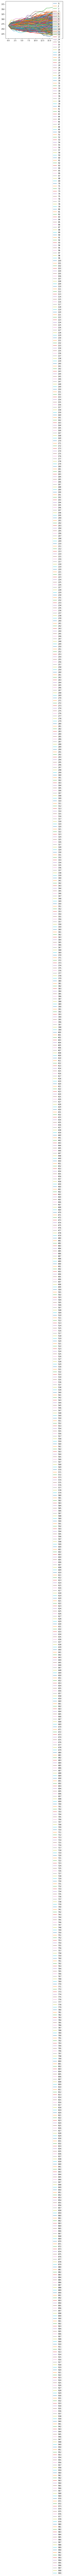

In [68]:
values_df.plot()

In [80]:
w = list(values_df.iloc[-1:])

5.2991455386337485


271.0
275.0
302.0
270.0
277.0
262.0
269.0
297.0
289.0
263.0
282.0
253.0
263.0
315.0
267.0
290.0
277.0
285.0
287.0
259.0
263.0
294.0
268.0
269.0
249.0
334.0
284.0
263.0
269.0
284.0
217.0
286.0
290.0
267.0
306.0
268.0
268.0
274.0
287.0
271.0
246.0
270.0
305.0
279.0
275.0
255.0
234.0
288.0
256.0
278.0
266.0
306.0
286.0
237.0
256.0
280.0
285.0
293.0
264.0
272.0
278.0
247.0
279.0
282.0
274.0
276.0
285.0
255.0
255.0
276.0
247.0
262.0
219.0
266.0
251.0
275.0
263.0
235.0
283.0
247.0
261.0
259.0
284.0
237.0
241.0
315.0
279.0
263.0
307.0
259.0
264.0
279.0
315.0
284.0
262.0
272.0
275.0
252.0
250.0
257.0
274.0
223.0
270.0
294.0
236.0
303.0
285.0
260.0
268.0
339.0
286.0
259.0
278.0
273.0
265.0
293.0
258.0
298.0
290.0
242.0
227.0
238.0
265.0
265.0
276.0
305.0
264.0
269.0
263.0
305.0
289.0
300.0
256.0
305.0
246.0
266.0
268.0
281.0
272.0
268.0
298.0
270.0
275.0
278.0
293.0
266.0
241.0
280.0
275.0
276.0
259.0
289.0
269.0
258.0
267.0
256.0
286.0
284.0
269.0
285.0
267.0
262.0
327.0
284.0
280.0
233.0
324.

In [111]:
result

,Payout,Payout,Payout,Total
Price,,,,
0,-200.3324,133.393777,-18.269922,-85.208545
1,-200.3324,133.393777,-18.269922,-85.208545
2,-200.3324,133.393777,-18.269922,-85.208545
3,-200.3324,133.393777,-18.269922,-85.208545
4,-200.3324,133.393777,-18.269922,-85.208545
...,...,...,...,...
555,27299.6676,-52866.606223,25481.730078,-85.208545
556,27399.6676,-53066.606223,25581.730078,-85.208545
557,27499.6676,-53266.606223,25681.730078,-85.208545
